# GIK2NX - Assignment 1 - Group 7

Authors:

  - Sebastian Danielsson
  - Jesper Andersson
  - Veronika Engberg

## Simulation 1

In [21]:
import numpy as np
import random
import mesa
import matplotlib.pyplot as plt


### Run with distribution of wealth between 0-5

In [22]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.remove(self)

        # Filter out cellmates with equal or more wealth
        poorer_cellmates = [cellmate for cellmate in cellmates if cellmate.wealth < self.wealth]

        if poorer_cellmates:
            # Select the cellmate with the least wealth
            min_wealth_cellmate = min(poorer_cellmates, key=lambda cellmate: cellmate.wealth)
            min_wealth_cellmate.wealth += 1
            self.wealth -= 1


    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            a.wealth = random.randint(0, 5)  # Comment out to restore money_agent.ipynb behaviour
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


In [23]:
model = MoneyModel(100, 10, 10)
for i in range(100):
    model.step()
# Print all unique wealth values and their counts
unique, counts = np.unique([agent.wealth for agent in model.schedule.agents], return_counts=True)
print(np.asarray((unique, counts)).T)


[[ 2 56]
 [ 3 44]]


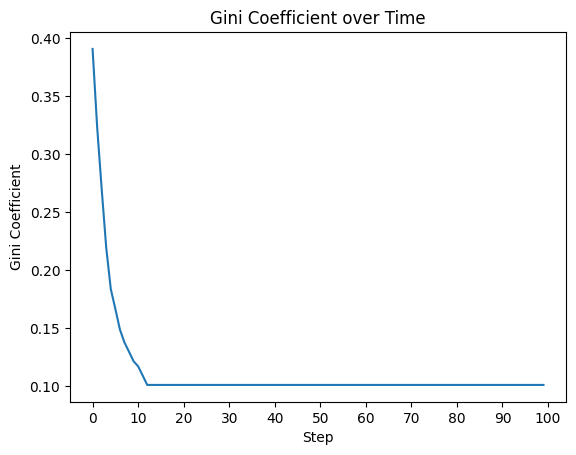

In [24]:
# Plot the Gini coefficient over time
gini = model.datacollector.get_model_vars_dataframe()
plt.plot(gini)
plt.title("Gini Coefficient over Time")
plt.xlabel("Step")
plt.ylabel("Gini Coefficient")
plt.xticks(np.arange(0, 100.1, 10))
plt.show()


### Run with distribution of wealth between 0-20

In [25]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.remove(self)

        # Filter out cellmates with equal or more wealth
        poorer_cellmates = [cellmate for cellmate in cellmates if cellmate.wealth < self.wealth]

        if poorer_cellmates:
            # Select the cellmate with the least wealth
            min_wealth_cellmate = min(poorer_cellmates, key=lambda cellmate: cellmate.wealth)
            min_wealth_cellmate.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            a.wealth = random.randint(0, 20)  # Comment out to restore money_agent.ipynb behaviour
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


In [26]:
model = MoneyModel(100, 10, 10)
for i in range(100):
    model.step()
# Print all unique wealth values and their counts
unique, counts = np.unique([agent.wealth for agent in model.schedule.agents], return_counts=True)
print(np.asarray((unique, counts)).T)


[[10 74]
 [11 26]]


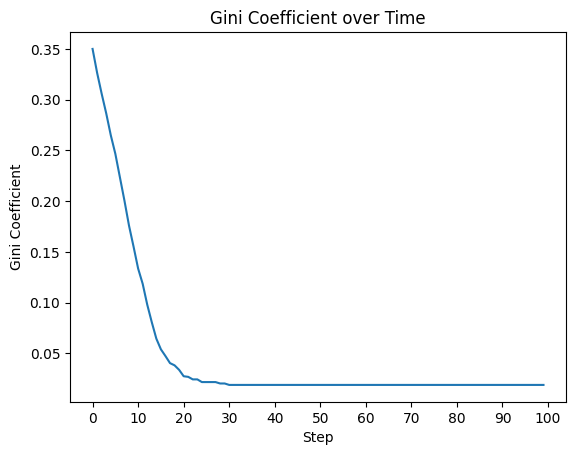

In [27]:
# Plot the Gini coefficient over time
gini = model.datacollector.get_model_vars_dataframe()
plt.plot(gini)
plt.title("Gini Coefficient over Time")
plt.xlabel("Step")
plt.ylabel("Gini Coefficient")
plt.xticks(np.arange(0, 100.1, 10))
plt.show()


## Simulation 2

Tasks:

1. Create at least 10 cars/vehicles as agents.
2. Create at least 5 parking spaces as agents.
3. Create a parking lot model using multigrid.
4. At each step the car should move and find the parking space. You can decide how the car
moves to reach the parking space.
5. Let the car leave the parking space after 3 to 5 steps.
6. Store the data on steps using data collector and show how many steps it took the cars to
occupy a parking space.
7. Display this simulation graphically.
8. Increase or decrease parking spaces and cars and see how it simulates. Provide your
reflection on this.
9. (Optional) Create an obstacle in the parking lot which can represent trees, use A*
algorithm to move the car towards the parking space.

Tips:

Create parking spaces:
```python
parking_spaces = [(1, 1), (3, 1), (5, 1), (7, 1), (9, 1)]
for i, space in enumerate(parking_spaces):
    if self.grid.width > space[0] and self.grid.height > space[1]:
        agent = ParkingSpaceAgent (i, self)
        self.grid.place_agent(agent, space)
        self.schedule.add(agent)
```

In [28]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from IPython.display import Video

class CarAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.parked = False
        self.steps_to_park = 0
        self.successfully_parked = False

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        self.model.grid.move_agent(self, random.choice(possible_steps))

    def step(self):
        if not self.parked:
            self.move()
            self.steps_to_park += 1
            this_cell = self.model.grid.get_cell_list_contents([self.pos])
            for agent in this_cell:
                if isinstance(agent, ParkingSpaceAgent) and not agent.occupied:
                    self.parked = True
                    self.successfully_parked = True
                    agent.occupy(self)
                    self.model.datacollector.collect(self.model)

    def try_leaving(self):
        if self.parked and random.randint(3, 5) <= self.steps_to_park:
            self.parked = False
            parking_space = self.model.grid.get_cell_list_contents([self.pos])[0]
            parking_space.vacate()

            # Collect final data before removal
            self.model.datacollector.collect(self.model)

            # Remove the car from the grid and the schedule
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)

class ParkingSpaceAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.occupied = False
        self.car = None

    def occupy(self, car):
        self.occupied = True
        self.car = car

    def vacate(self):
        self.occupied = False
        self.car = None

    def step(self):
        if self.occupied and self.car:
            self.car.try_leaving()

class ParkingLotModel(Model):
    def __init__(self, num_cars, width, height, parking_spaces):
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.grid_states = []
        self.datacollector = DataCollector(
            agent_reporters={"StepsToPark": "steps_to_park", "SuccessfullyParked": "successfully_parked"}
        )

        car_agent_id = 0
        parking_space_agent_id = 1000

        for space in parking_spaces:
            if self.grid.width > space[0] and self.grid.height > space[1]:
                agent = ParkingSpaceAgent(parking_space_agent_id, self)
                self.grid.place_agent(agent, space)
                self.schedule.add(agent)
                parking_space_agent_id += 1

        # Create cars
        for _ in range(num_cars):
            car = CarAgent(car_agent_id, self)
            self.grid.place_agent(car, (0, 0))  # Starting position for all cars
            self.schedule.add(car)
            car_agent_id += 1

    def get_grid_state(self):
        grid_state = np.zeros((self.grid.width, self.grid.height))
        # First, mark all parking spaces (occupied or empty)
        for agent in self.schedule.agents:
            if isinstance(agent, ParkingSpaceAgent):
                x, y = agent.pos
                grid_state[x, y] = 1 if agent.occupied else 3  # 1 for occupied, 3 for empty ParkingSpaceAgent

        # Then, mark cars, but only in non-parking spaces
        for agent in self.schedule.agents:
            if isinstance(agent, CarAgent):
                x, y = agent.pos
                if grid_state[x, y] not in [1, 3]:  # Check if it's not a parking space
                    grid_state[x, y] = 2  # Representing CarAgent
        return grid_state

    def step(self):
        self.schedule.step()
        self.grid_states.append(self.get_grid_state())

# Run the model function
def runModel(num_cars, width, height, parking_spaces):
    model = ParkingLotModel(num_cars, width, height, parking_spaces)
    for i in range(20):
        model.step()
    return model

# Plot data function
def plotData(data):
    # Assuming 'data' is the DataFrame you obtained from your model's DataCollector
    # Filter and aggregate data
    car_data = data[data.index.get_level_values('AgentID') < 1000]
    steps_to_park_data = car_data.groupby('AgentID')['StepsToPark'].max()
    successfully_parked_data = car_data.groupby('AgentID')['SuccessfullyParked'].max()

    # Determine color based on whether they successfully parked
    colors = ['red' if not parked else 'blue' for parked in successfully_parked_data.values]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(steps_to_park_data.index, steps_to_park_data.values, color=colors)
    plt.xlabel('Car Agent ID')
    plt.ylabel('Steps to Park')
    plt.title('Number of Steps Each Car Took to Park (Red indicates not parked)')
    plt.xticks(steps_to_park_data.index)
    plt.tight_layout()
    plt.show()

# Generate video of each step
def generate_video(model, filename):
    cmap = ListedColormap(['white', 'red', 'blue', 'green'])

    fig, ax = plt.subplots(figsize=(5, 5))

    def animate(i):
        ax.clear()
        ax.imshow(model.grid_states[i], cmap=cmap, interpolation='nearest')
        ax.set_title(f"Step {i+1}")

    ani = animation.FuncAnimation(fig, animate, frames=len(model.grid_states), interval=3000)
    ani.save(filename, writer='ffmpeg')
    plt.close()


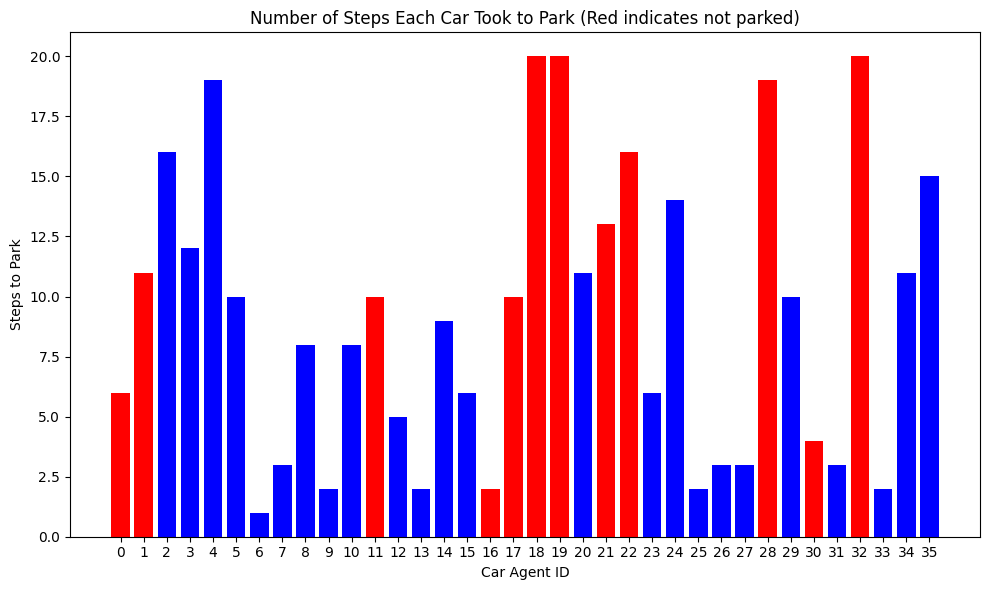

In [29]:
# Configure the model
num_cars = 36
width = 7
weight = 9
parking_spaces = [(1, 1), (1, 2), (1, 3), (1, 5), (1, 6), (1, 7),
                    (3, 1), (3, 2), (3, 3), (3, 5), (3, 6), (3, 7),
                    (5, 1), (5, 2), (5, 3), (5, 5), (5, 6), (5, 7)]

# Create the model and run it for 20 steps
model = runModel(num_cars, width, weight, parking_spaces)
data = model.datacollector.get_agent_vars_dataframe()

plotData(data)

# Generate a video of the simulation
filename = 'parking_lot_simulation_36_cars.mp4'
generate_video(model, filename)

# Show the video
Video(filename, embed=True)


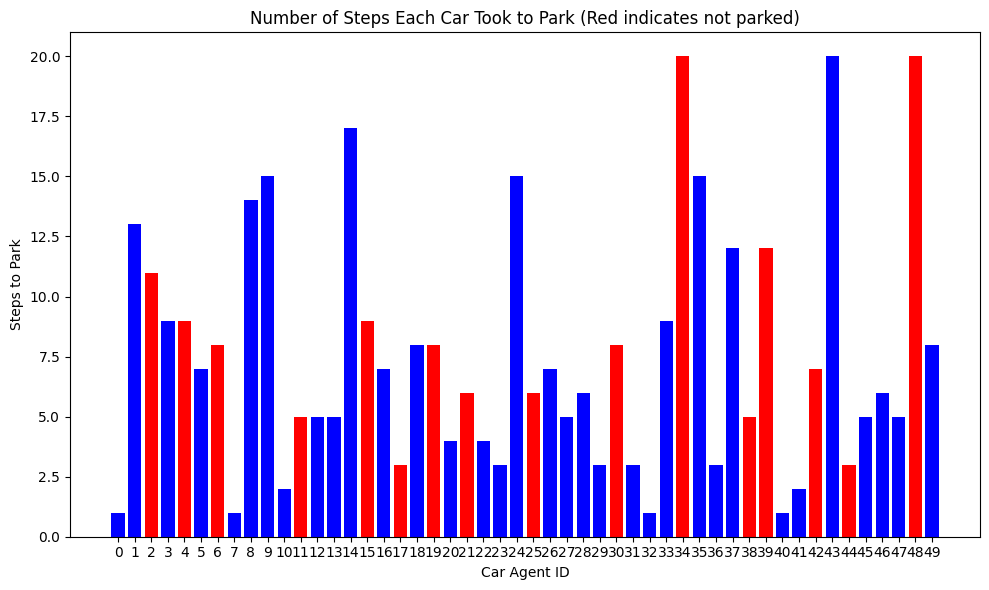

In [31]:
# Configure the model
num_cars = 50
width = 7
weight = 9
parking_spaces = [(1, 1), (1, 2), (1, 3), (1, 5), (1, 6), (1, 7),
                    (3, 1), (3, 2), (3, 3), (3, 5), (3, 6), (3, 7),
                    (5, 1), (5, 2), (5, 3), (5, 5), (5, 6), (5, 7)]

# Create the model and run it for 20 steps
model = runModel(num_cars, width, weight, parking_spaces)
data = model.datacollector.get_agent_vars_dataframe()

# Plot the data
plotData(data)

# Generate a video of the simulation
filename = 'parking_lot_simulation_50_cars.mp4'
generate_video(model, filename)

# Show the video
Video(filename, embed=True)
